# CSP Features 

### Steps of FB-CSP Classification 
(Fast EEG-Based Decoding Of The Directional Focus Of Auditory Attention Using Common Spatial Patterns)
- Step 1: Filter Bank
    - 14(B is number of filter bank) 8th-order butterworth filters. The first filter corresponds to frequency band 1-4 hz. The second with 2-6. And continuous with overlap 2 hz until 26(2+12*2)-30 hz. 
    - Downsample to 64 hz. (先不做)
- Step 2: CSP
    - How to choice the filter? RMOE (in this paper) vs. Covariance (mne, or common methods)
    - Choice k components from CSP filter
- Step 3: Log Energy
    - Summation the CSP pattern and calculate the log energy of every band and k filters
    - Output feature: Filter Bank B x k components
    - This step will be done by mne.decoding.csp.
- Step 4: Classification  
    - lda, svm

### Data pipline or workflow
Theres two task of the works. Binary classification vs. Multi-class
First in single classes
- Data Prepration: 
    - Input Data: 2(class) x 25(subjects) x 32/2(trials, unknown?) x channel num x trials timepoint
    - Output Data: channel num x 2(class) x segments numbers[subjects x trials x decision windows numbers] x decision windows size (4sec x 128hz)
- Step 1: Filter Bank
    - Input Data: (channel num, 2 x segments numbers, 512)
    - Ouput Data: 2, segments numbers, 14 bank num, 512
- Step 2: CSP
    - Input Data: (s)

### Step 1 - Data Prepration

In [2]:
import mne
import h5py
import numpy as np
import os
import scipy.io
import pandas as pd

# 使用範例
path = "./NJUNCA_preprocessed_arte_removed/"
expinfo_path = path + "expinfomat_csvs/"
mat_files = [f for f in os.listdir(path) if f.endswith('.mat')]
print(mat_files)    # 前兩個是info資料從第三個開始讀

subjects = 21
fs = 128  # sampling frequency
window_sec = 4
window_size = fs * window_sec  # 512
channels = 32  # assume full 32 channels
count = 0
side_dict = {
    "right": 0,
    "left": 1,
}


# Load data
all_segments = []
all_labels = []
all_trials = []
pre_trial_idx = 0

for subj in range(2, subjects):
    data_path = path + mat_files[subj]
    file = h5py.File(data_path, 'r')
    csv_path = expinfo_path + mat_files[subj].replace('.mat', '.csv')
    df = pd.read_csv(csv_path)['attended_lr']

    ref_data = file['data']
    ref_eeg = ref_data['eeg']
    ref_leftangle = ref_data['event']['leftWav']
    ref_rightangle = ref_data['event']['rightWav']
    ref_attenside = ref_data['event']['eeg']
    trials = len(ref_eeg[:])

    for trial in range(trials):
        try:
            left_angel_reg = file[ref_leftangle['value'][trial][0]]
            left_angel = file[left_angel_reg[0][0]][0][0]
            right_angel_reg = file[ref_rightangle['value'][trial][0]]
            right_angel = file[right_angel_reg[0][0]][0][0]

            if (left_angel*-1) != right_angel:
                print(f"{mat_files[subj]}-{trial}: {left_angel}/{right_angel} not the same angle ")
                continue
            # if abs(right_angel) != 90:
            #     print(f"{mat_files[subj]}-{trial}: {left_angel}/{right_angel} not 90 degree")
            #     continue
            print(f"{mat_files[subj]}-{trial}: {left_angel}/{right_angel}")
            ref = ref_eeg[trial][0]
            eeg_data = np.array(file[ref][:]) # shape: 32, time
            trial_len = eeg_data.shape[1]
            
            # Segment into 4-second windows (non-overlapping)
            n_windows = trial_len // window_size
            
            for win in range(n_windows):
                segment = eeg_data[:, win * window_size : (win + 1) * window_size]  # shape: (channels, 512)
                count += 1
                all_segments.append(segment)
                all_labels.append(side_dict[df[trial]])

            # write trial info dict
            trial_info = {
                "subject_name": mat_files[subj].split('.')[0],
                "trial":trial,
                "attention_side": df[trial],
                "left_angel": left_angel,
                "right_angel": right_angel,
                "trial_start": pre_trial_idx,
                "trial_end": count,
            }
            all_trials.append(trial_info)
            pre_trial_idx = count 
        except:
            print(mat_files[subj], trial, 'load error')
    print(f"{mat_files[subj]} cumulated segments:{count}")



# Convert to numpy arrays
X = np.stack(all_segments)  # shape: (total_segments, channels, 512)
y = np.array(all_labels)    # shape: (total_segments,)

print("Data shape:", X.shape)
print("Labels shape:", y.shape)

n_epochs, n_channels, n_times = X.shape
sfreq = 128  # sampling frequency

# 建立 channel info
# 你給的通道名稱
ch_names = [
    'Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1',
    'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6',
    'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2'
]
ch_types = ['eeg'] * n_channels
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# 建立 event array
# MNE 的 events shape 是 (n_epochs, 3)，通常中間值無用
# 最後一欄是 class label，需要轉換成 event id 後對應 dict
events = np.column_stack((
    np.arange(len(y)),  # arbitrary sample indices
    np.zeros(len(y), dtype=int),  # filler
    y
))

# 建立 event_id 字典
event_id = {f'class_{i}': i for i in np.unique(y)}

# 轉成 EpochsArray
epochs = mne.EpochsArray(X, info, events=events, event_id=event_id, verbose=False)
montage = mne.channels.make_standard_montage('standard_1020')
epochs.set_montage(montage)

# 檢查一下
print(epochs)
# epochs.plot(n_epochs=5, n_channels=10)

['azimuthmat.mat', 'expinfomat.mat', 'S02.mat', 'S03.mat', 'S04.mat', 'S06.mat', 'S07.mat', 'S09.mat', 'S12.mat', 'S13.mat', 'S15.mat', 'S16.mat', 'S17.mat', 'S18.mat', 'S19.mat', 'S21.mat', 'S22.mat', 'S23.mat', 'S25.mat', 'S26.mat', 'S27.mat']
S02.mat-0: -90.0/90.0
S02.mat-1: -90.0/90.0
S02.mat-2: -135.0/135.0
S02.mat-3: -135.0/135.0
S02.mat-4: 30.0/60.0 not the same angle 
S02.mat-5: 30.0/60.0 not the same angle 
S02.mat-6: 0.0/0.0
S02.mat-7: 0.0/0.0
S02.mat-8: -30.0/-90.0 not the same angle 
S02.mat-9: -30.0/-90.0 not the same angle 
S02.mat-10: 30.0/90.0 not the same angle 
S02.mat-11: 30.0/90.0 not the same angle 
S02.mat-12: -120.0/120.0
S02.mat-13: -120.0/120.0
S02.mat-14: -15.0/15.0
S02.mat-15: -15.0/15.0
S02.mat-16: -30.0/-60.0 not the same angle 
S02.mat-17: -30.0/-60.0 not the same angle 
S02.mat-18: -45.0/45.0
S02.mat-19: -45.0/45.0
S02.mat-20: -60.0/60.0
S02.mat-21: -60.0/60.0
S02.mat-22: -30.0/30.0
S02.mat-23: -30.0/30.0
S02.mat-24: -90.0/-45.0 not the same angle 
S02.ma

### Subject Group 

In [25]:
group_ = [(2, 7), (8, 15), (16, 19), (21, 23), (25, 27)]  # 5 groups
group_index_list = [[] for _ in range(len(group_))]      # list of 5 empty lists

cum_trials = 0 
for idx, info_dict in enumerate(all_trials):
    # print(f"{idx}-{info_dict['subject_name']}/{info_dict['trial']} - cumulated trials rate:{info_dict['trial_end']/count}")

    if abs(info_dict['left_angel']) != 90:
        continue

    subject_int = int(info_dict['subject_name'].replace('S', ''))

    # 分配到對應的 group
    for group_id, (low, high) in enumerate(group_):
        if low <= subject_int <= high:
            trial_range = range(info_dict['trial_start'] + 1, info_dict['trial_end'] + 1)
            cum_trials += len(trial_range)
            group_index_list[group_id].extend(trial_range)
            break

cum_ratio = 0
for g_l in group_index_list:
    trial_ratio = len(g_l)/cum_trials
    cum_ratio += trial_ratio
    print(trial_ratio, cum_ratio)



0.13907849829351535 0.13907849829351535
0.128839590443686 0.26791808873720135
0.1407849829351536 0.408703071672355
0.31399317406143346 0.7226962457337884
0.2773037542662116 1.0


### Training set and testing set

In [33]:
from sklearn.model_selection import train_test_split

# # 先產生 train/test 的 index
# train_idx, test_idx = train_test_split(np.arange(len(epochs)), test_size=0.2, stratify=y, random_state=42)

# # 使用 MNE 的索引方式選出對應 epoch
# train_epochs = epochs[train_idx].copy()
# test_epochs = epochs[test_idx].copy()
# train_y = y[train_idx]
# test_y = y[test_idx]


# bands = {
#     '1': (1, 4),
#     '2': (2, 6),
#     '3': (4, 8),
# }
bands = {
    '1': (12, 30),
}

# for iter_ in range(4, 15):
#     pre_low, pre_high = bands[str(iter_-1)]
#     bands[str(iter_)] = (pre_low+2, pre_high+2)

_ = leaveonegroupout(group_index_list, epochs, y, bands)

--------------------------------------------------------------------------------------------------------------



	Group:0

--------------------------------------------------------------------------------------------------------------


Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 s)



[Parallel(n_jobs=1)]: Done 32288 out of 32288 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 5216 out of 5216 | elapsed:    0.4s finished


    Using tolerance 1.2e+02 (2.2e-16 eps * 32 dim * 1.7e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
--------------------------------------------------------------------------------------------------------------



	Group:1

--------------------------------------------------------------------------------------------------------------


Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 s)



[Parallel(n_jobs=1)]: Done 32672 out of 32672 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 4832 out of 4832 | elapsed:    0.3s finished


    Using tolerance 1.2e+02 (2.2e-16 eps * 32 dim * 1.7e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
--------------------------------------------------------------------------------------------------------------



	Group:2

--------------------------------------------------------------------------------------------------------------


Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 s)



[Parallel(n_jobs=1)]: Done 32224 out of 32224 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 5280 out of 5280 | elapsed:    0.4s finished


    Using tolerance 1.2e+02 (2.2e-16 eps * 32 dim * 1.6e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
--------------------------------------------------------------------------------------------------------------



	Group:3

--------------------------------------------------------------------------------------------------------------


Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 s)



[Parallel(n_jobs=1)]: Done 25728 out of 25728 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 11776 out of 11776 | elapsed:    1.1s finished


    Using tolerance 1.2e+02 (2.2e-16 eps * 32 dim * 1.7e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
--------------------------------------------------------------------------------------------------------------



	Group:4

--------------------------------------------------------------------------------------------------------------


Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 s)



[Parallel(n_jobs=1)]: Done 27104 out of 27104 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 10400 out of 10400 | elapsed:    1.0s finished


    Using tolerance 1.1e+02 (2.2e-16 eps * 32 dim * 1.6e+16  max singular value)
    Estimated rank (data): 32
    data: rank 32 computed from 32 data channels with 0 projectors
Reducing data rank from 32 -> 32
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
[SVM] Accuracy: 0.5742-0.5470, F1: 0.5740, Group-std: 0.1518
[LDA] Accuracy: 0.5845-0.5523, F1: 0.5782, Group-std: 0.1016


### Step 2 - CSP and Log Power

In [27]:
from mne.decoding import CSP
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report


def do_csp(bands, train_epochs, test_epochs, train_y, test_y):
    csp_list = []
    train_features = []
    test_features = []

    for name, (l_freq, h_freq) in bands.items():
        # if l_freq == 14:
        # Band-pass filter
        train_epochs_band = train_epochs.copy().filter(l_freq, h_freq, fir_design='firwin').get_data(copy=False)
        test_epochs_band = test_epochs.copy().filter(l_freq, h_freq, fir_design='firwin').get_data(copy=False)

        # Fit CSP on this band
        csp = CSP(n_components=4, reg='ledoit_wolf')
        train_csp = csp.fit_transform(train_epochs_band, train_y)  # labels: array of class labels
        csp_list.append(csp)
        test_csp = csp.transform(test_epochs_band)

        train_features.append(train_csp)
        test_features.append(test_csp)

    train_CSP_features = np.concatenate(train_features, axis=1)
    test_CSP_features = np.concatenate(test_features, axis=1)
    # print(train_CSP_features.shape, test_CSP_features.shape)

    # Define a monte-carlo cross-validation generator (reduce variance):
    cv = ShuffleSplit(10, test_size=0.2, random_state=42)

    # Assemble a classifier
    lda = LinearDiscriminantAnalysis()
    svc = svm.SVC()

    svc_scores = cross_val_score(svc, train_CSP_features, train_y, cv=cv, n_jobs=None)
    lda_scores = cross_val_score(lda, train_CSP_features, train_y, cv=cv, n_jobs=None)

    svc.fit(train_CSP_features, train_y)
    svm_pred_y = svc.predict(test_CSP_features)

    lda.fit(train_CSP_features, train_y)
    lda_pred_y = lda.predict(test_CSP_features)

    return svm_pred_y, lda_pred_y, csp_list


### Step 3 - Do Leave one group out

In [34]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def leaveonegroupout(group_index, epochs, y, bands):

    pred_svm = []
    pred_lda = []
    true_labels = []
    csp_list = []

    acc_svm_list = []
    acc_lda_list = []
    
    for valid_group in range(len(group_index)):
        print(f"--------------------------------------------------------------------------------------------------------------\n\n")
        print(f"\n\tGroup:{valid_group}\n")
        print(f"--------------------------------------------------------------------------------------------------------------\n\n")
        test_idx = group_index[valid_group]
        # Flatten all other groups into train_idx
        train_idx = [i for g, indices in enumerate(group_index) if g != valid_group for i in indices]

        train_epochs = epochs[train_idx].copy()
        test_epochs = epochs[test_idx].copy()
        train_y = y[train_idx]
        test_y = y[test_idx]

        # print(X_train.shape, len(y_train), X_test.shape, len(y_test))

        temp_svm_pred_y, temp_lda_pred_y, temp_csp_list = do_csp(bands, train_epochs, test_epochs, train_y, test_y)
        pred_svm.extend(temp_svm_pred_y)
        pred_lda.extend(temp_lda_pred_y)
        csp_list.extend(temp_csp_list)
        true_labels.extend(test_y)

        # Compute per-group accuracy
        acc_svm = accuracy_score(test_y, temp_svm_pred_y)
        acc_lda = accuracy_score(test_y, temp_lda_pred_y)

        acc_svm_list.append(acc_svm)
        acc_lda_list.append(acc_lda)

    # Convert to numpy arrays
    pred_svm = np.array(pred_svm)
    pred_lda = np.array(pred_lda)
    true_labels = np.array(true_labels)

    # Global metrics
    acc_svm_total = accuracy_score(true_labels, pred_svm)
    acc_lda_total = accuracy_score(true_labels, pred_lda)
    f1_svm = f1_score(true_labels, pred_svm, average='macro')
    f1_lda = f1_score(true_labels, pred_lda, average='macro')

    # Group-level std.
    std_svm = np.std(acc_svm_list)
    avg_svm = np.mean(acc_svm_list)
    std_lda = np.std(acc_lda_list)
    avg_lda = np.mean(acc_lda_list)

    print(f"[SVM] Accuracy: {acc_svm_total:.4f}-{avg_svm:.4f}, F1: {f1_svm:.4f}, Group-std: {std_svm:.4f}")
    print(acc_svm_list)
    print(f"[LDA] Accuracy: {acc_lda_total:.4f}-{avg_lda:.4f}, F1: {f1_lda:.4f}, Group-std: {std_lda:.4f}")
    print(acc_lda_list)

    return acc_svm_total, f1_svm, std_svm, acc_lda_total, f1_lda, std_lda, csp_list
        

Filter Bank band: (1, 4)


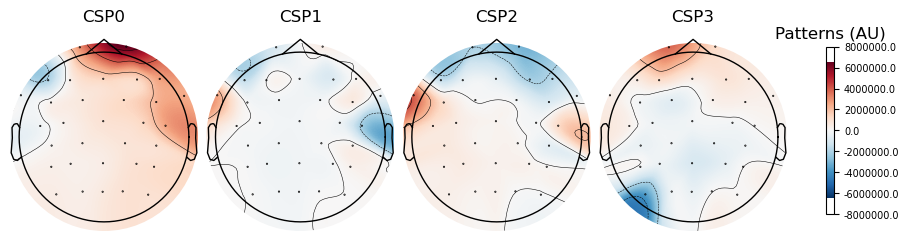

Filter Bank band: (2, 6)


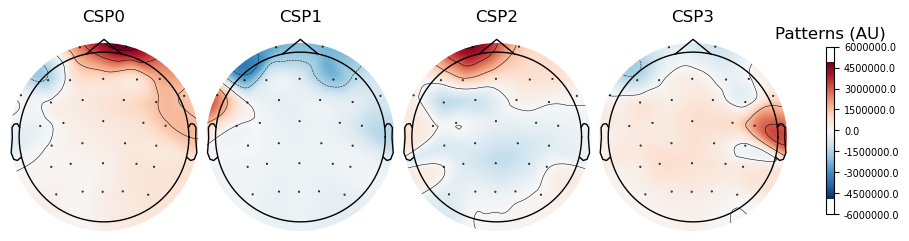

Filter Bank band: (4, 8)


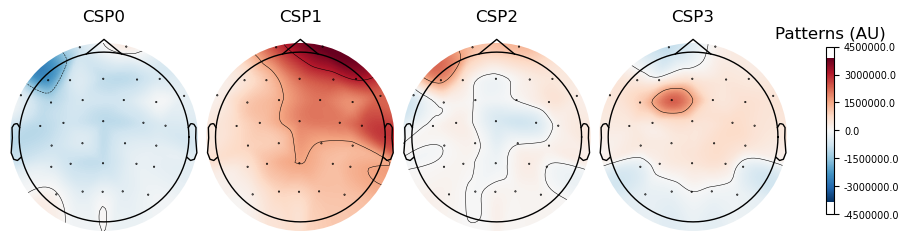

Filter Bank band: (6, 10)


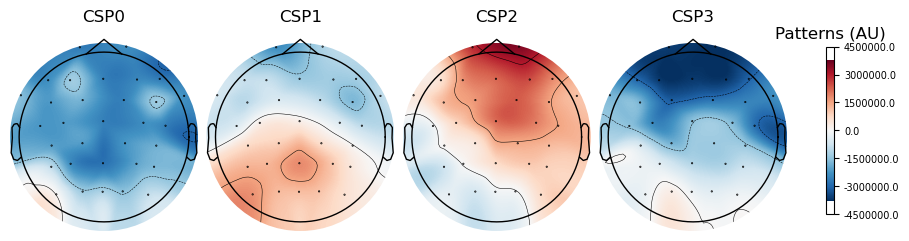

Filter Bank band: (8, 12)


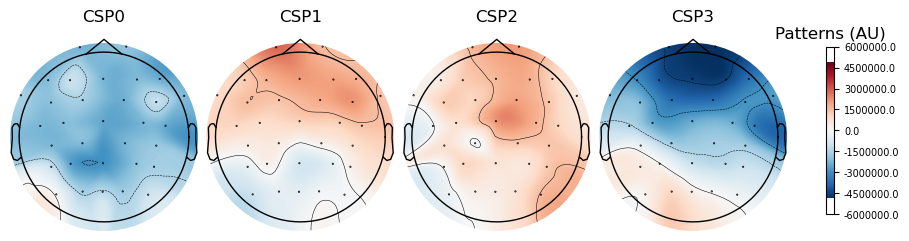

Filter Bank band: (10, 14)


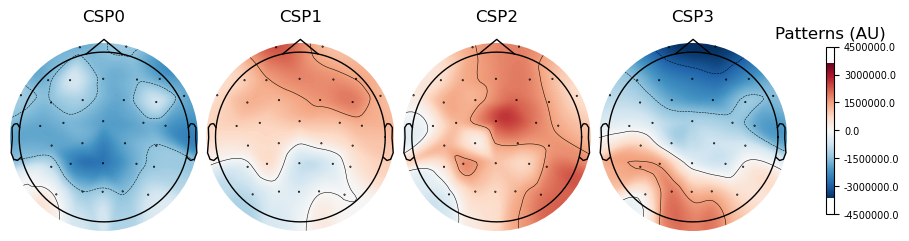

Filter Bank band: (12, 16)


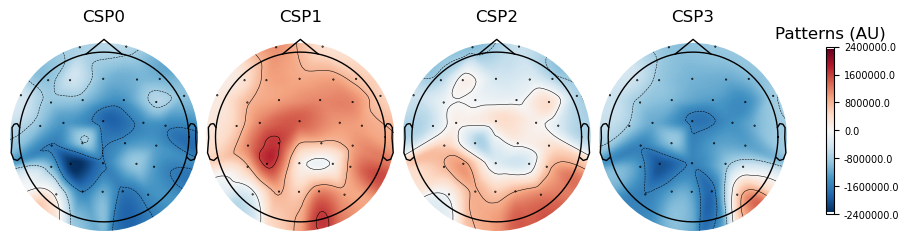

Filter Bank band: (14, 18)


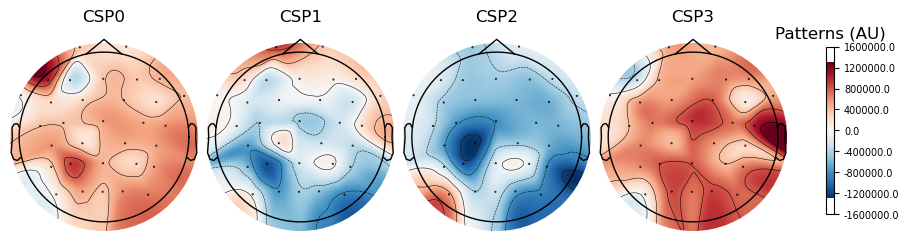

Filter Bank band: (16, 20)


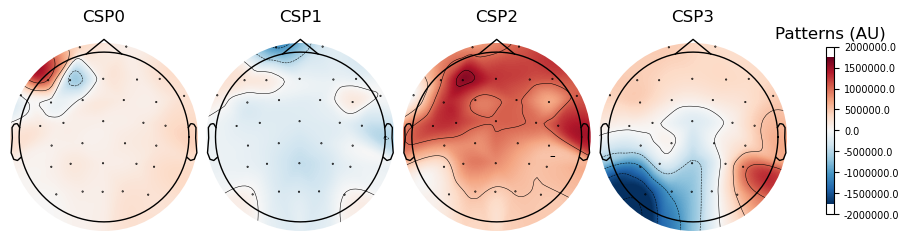

Filter Bank band: (18, 22)


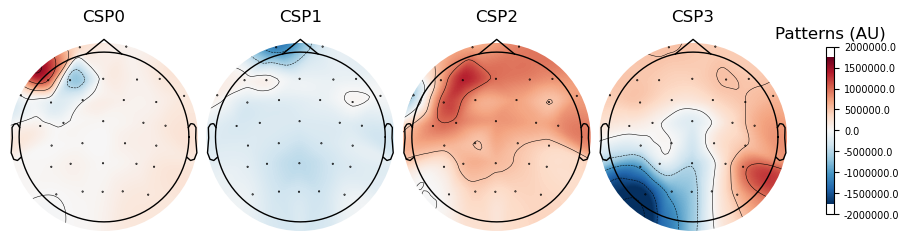

Filter Bank band: (20, 24)


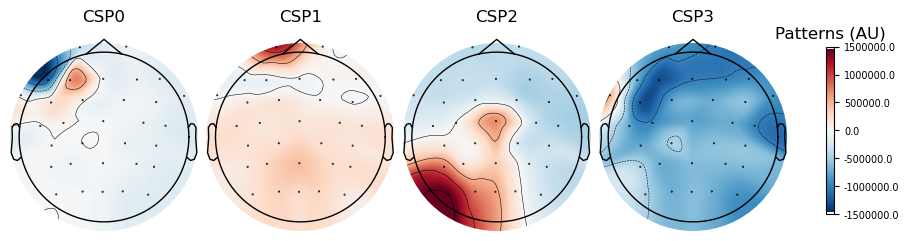

Filter Bank band: (22, 26)


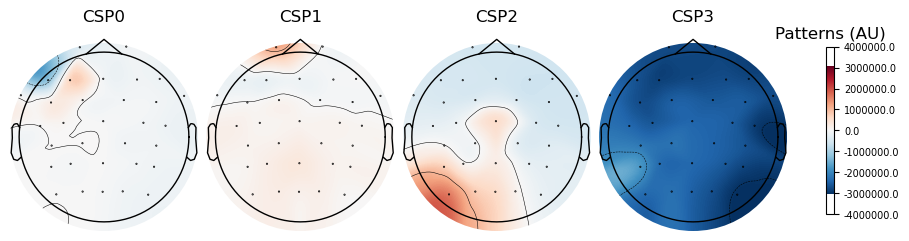

Filter Bank band: (24, 28)


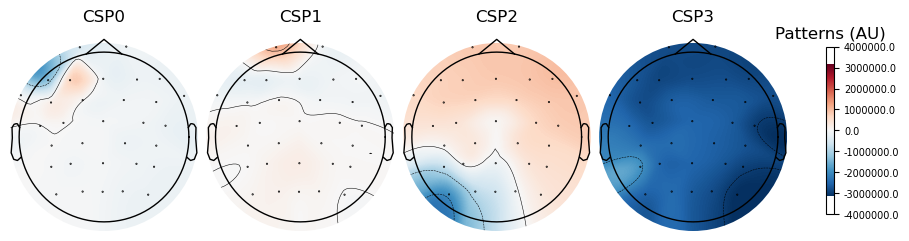

Filter Bank band: (26, 30)


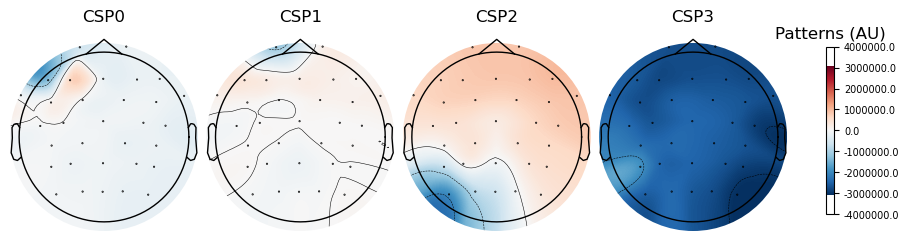

In [ ]:
for idx, csp in enumerate(csp_list):
    print(f"Filter Bank band: {bands[str(idx+1)]}")
    csp.plot_patterns(train_epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

### Mulit-class CSP
- 